Na aula de hoje, vamos falar sobre _séries temporais_, que nada mais são do que sequências de amostras com uma dependência temporal, como por exemplo uma série de leituras de um sensor de temperatura.

#### Definições

- Uma **série temporal** é uma sequência de amostras listadas por **ordem de tempo** - isto é, uma observação acontece **após** a outra. As séries temporais mais comuns são igualmente espaçadas no tempo, como por exemplo o valor de fechamento diário de uma ação na bolsa de valores.

- A **análise (analysis)** de séries temporais constitui um conjunto de técnicas para extrair informações e estatísticas úteis das séries. A **previsão (forecasting)** de séries temporais diz respeito à construção de um modelo para prever o comportamento futuro da série.

- Sinais de áudio também são séries temporais, mas são mais comumente tratados no domínio da frequência devido à natureza determinística do problema, com técnicas como análise espectral e transformações de Fourier ou Laplace.

- Problemas de natureza mais aleatória, que constituem a grande maioria dos problemas em aplicações de negócios, são normalmente tratados no domínio temporal, com técnicas como auto-correlação e correlação cruzada (similar à convolução).

- As séries temporais podem ou não ser _estacionárias_: se são, isto significa que sua média, seu desvio padrão e sua covariância permanecem constantes ao longo do tempo. Alguns exemplos de séries **não-estacionárias**:

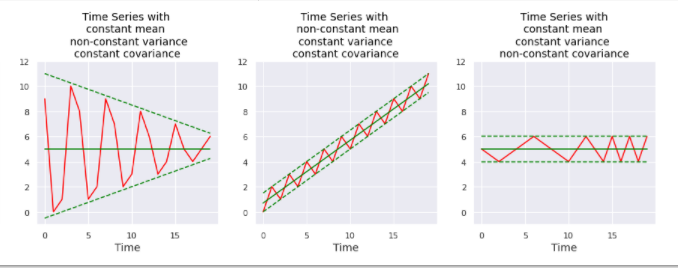

<br>

- A **tendência (trend)** de uma série temporal é a variação de sua média ao longo do tempo.
- A **sazonalidade (seasonality)** de uma série temporal é um padrão de variação que se repete com um período fixo.
- Os valores de tendência e sazonalidade podem ser removidos da série temporal original para obter uma série temporal estacionária.

#### Exemplos

Vamos gerar um exemplo básico de uma série temporal: um passeio aleatório. Começaremos no ponto $x=0$ e jogaremos uma moeda para decidir a direção do passo, sendo $x+1$ com probabilidade $p$ e $x-1$ com probabilidade $1-p$:

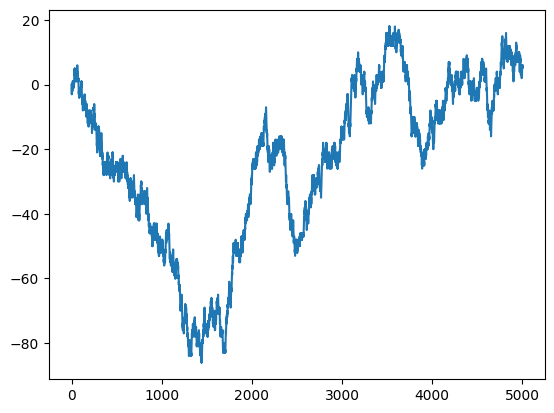

In [23]:
import numpy as np
p = 0.5
hist = [0]
for _ in range(5000):
    hist.append(hist[-1] + (1 if np.random.rand() > p else -1))
    
import seaborn as sns
sns.lineplot(hist);

Podemos ver nitidamente que a série produzida não é estacionária! Apesar de ter média constante, a variância do passeio aleatório só aumenta conforme o tempo passa. Note também que nossa "moeda" é justa - damos aproximadamente a mesma quantidade de passos em cada direção pois escolhemos com $50\%$ de chance cada uma. Vamos observar o que acontece caso usássemos uma moeda enviesada:

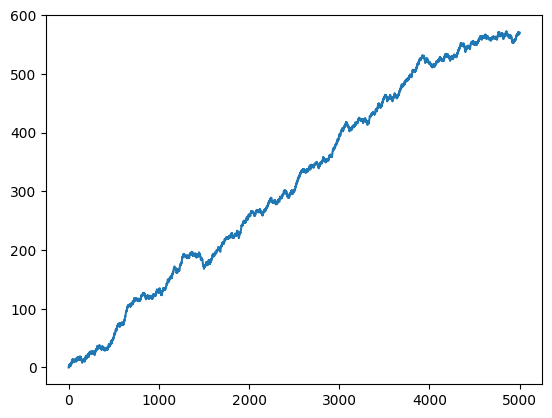

In [28]:
p = 0.45
hist = [0]
for _ in range(5000):
    hist.append(hist[-1] + (1 if np.random.rand() > p else -1))

sns.lineplot(hist);

Podemos observar evidentemente um padrão de crescimento! Este componente linear da série é a **tendência** e ela pode ser removida a fim de obtermos uma série com média estacionária. Neste caso específico, temos uma tendência _global_ na série que permanece constante ao longo do tempo (linear), e podemos removê-la calculando uma reta aproximada e subtraindo dos valores:

Diferença: 500.00000000000017


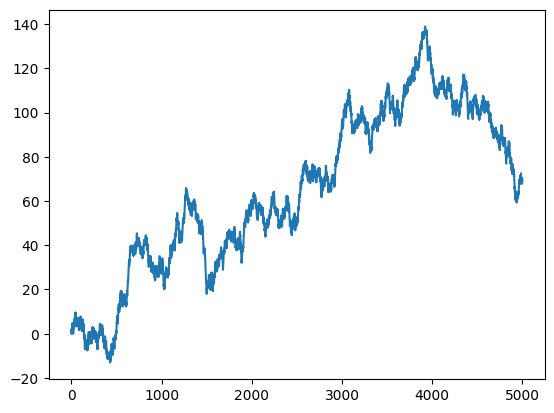

In [44]:
p = 0.45
# Quantos passos positivos demos a mais?
diff = 5000 * (0.45*(-1) + 0.55*(+1))
print('Diferença:', diff)
# 500 passos positivos a mais em 5000 passos, y = (500/5000)*x = 0.1*x
hist_diff = [hist[i] - 0.1*i for i in range(len(hist))]
sns.lineplot(hist_diff);

Podemos observar que a maior parte da tendência foi removida! Na prática, o que fizemos foi remover a tendência via um ajuste de modelo. Também é possível remover a tendência calculando a diferença entre as amostras $t$ e $t-1$.

Vamos carregar um dataset "real" - o _Sunspots_, um conjunto de observações sobre manchas solares do instituto americano National Geophysical Data Center:

In [55]:
import pandas as pd
df = pd.read_csv('sunspots.csv')

<Axes: xlabel='YEAR', ylabel='SUNACTIVITY'>

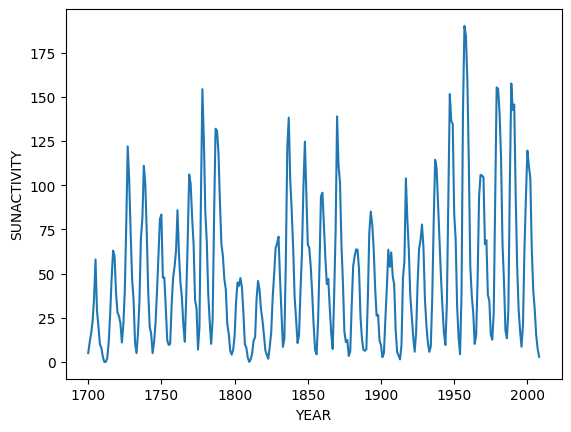

In [60]:
sns.lineplot(df, x='YEAR', y='SUNACTIVITY')

Nesta série podemos notar que há _sazonalidade_ - um padrão que se repete ao longo de um período fixo. É conhecido pela física um período de oscilação de ativiade solar de aproximadamente 11 anos - vamos tentar remover este efeito:

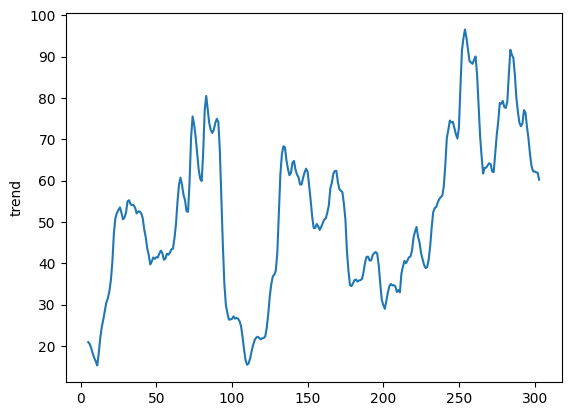

In [244]:
from statsmodels.tsa.seasonal import seasonal_decompose
nova_serie = seasonal_decompose(df['SUNACTIVITY']+1, model='additive', period=11)
sns.lineplot(nova_serie.trend);

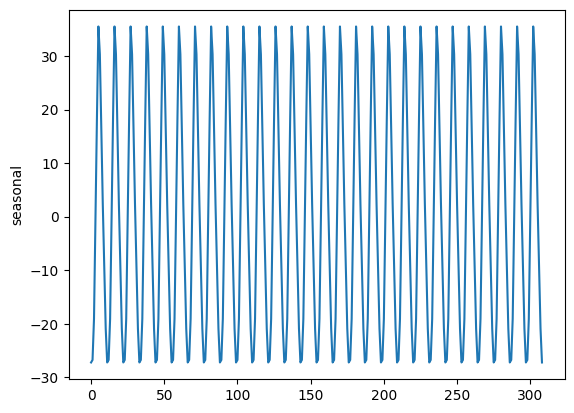

In [245]:
sns.lineplot(nova_serie.seasonal);

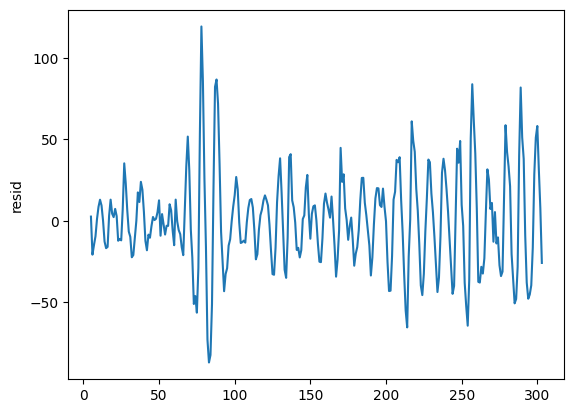

In [246]:
sns.lineplot(nova_serie.resid);

Vamos agora treinar um modelo para prever esta série temporal. Utilizaremos um _modelo sazonal auto-regressivo integrado de médias móveis_, ou _SARIMAX_. Na prática, o que este nome significa é que faremos uma auto-regressão - o valor futuro da variável depende dos valores atuais e anteriores. O parâmetro `order` representa a dependência de valores anteriores para as partes de auto-regressão, diferenciação e média móvel, respectivamente.

In [142]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [128]:
df_train = df.iloc[:150]
df_test = df.iloc[150:]

In [250]:
model = SARIMAX(df_train['SUNACTIVITY'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 11))
model = model.fit()

In [252]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_test['SUNACTIVITY'], model.forecast(steps=159), squared=False)

39.663740570934905

<Axes: ylabel='SUNACTIVITY'>

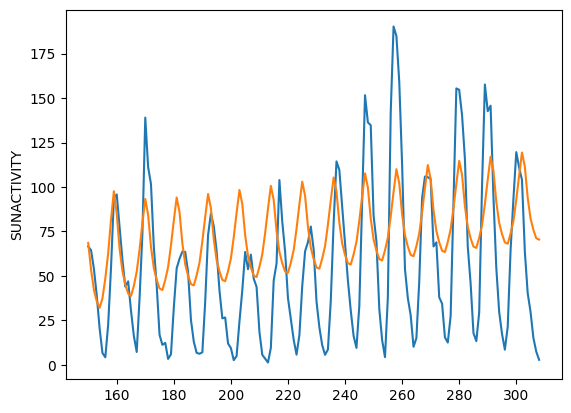

In [253]:
sns.lineplot(df_test['SUNACTIVITY'])
sns.lineplot(model.forecast(steps=159))

1332.4605480762013


<Axes: ylabel='SUNACTIVITY'>

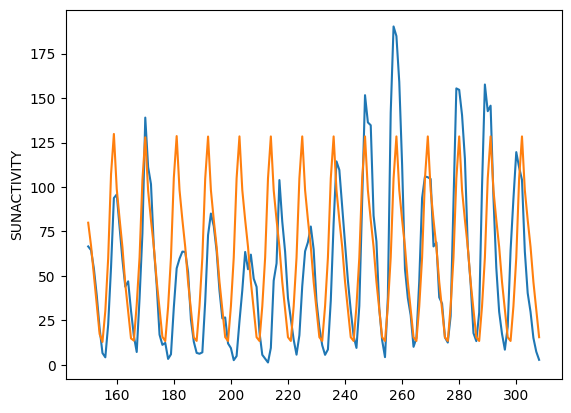

In [236]:
model = SARIMAX(df_train['SUNACTIVITY'], order=(1, 0, 1), seasonal_order=(1, 1, 0, 11)).fit()
print(mean_squared_error(df_test['SUNACTIVITY'], model.forecast(steps=159)))
sns.lineplot(df_test['SUNACTIVITY'])
sns.lineplot(model.forecast(steps=159))

In [255]:
df['SUNACTIVITY_2'] = df['SUNACTIVITY'].shift(1)

In [259]:
mean_squared_error(df['SUNACTIVITY'].iloc[1:], df['SUNACTIVITY_2'].iloc[1:])

574.8202272727273

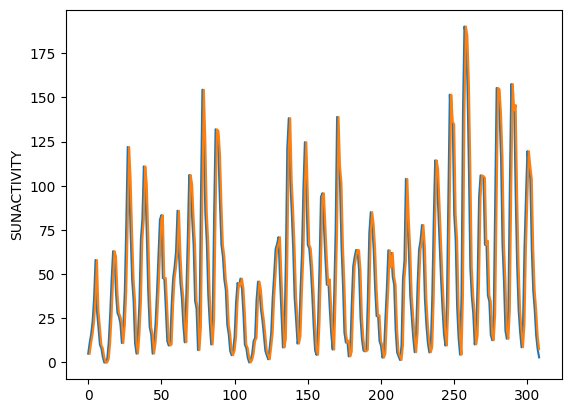

In [261]:
sns.lineplot(df['SUNACTIVITY']);
sns.lineplot(df['SUNACTIVITY_2']);